# Predicting Video Game Sales

## Notes for cleaning dataset
- 269 dates missing, often for Japanese Releases or Atari 2600 games
- 245 dates added, some games seem to have been cancelled for a platform although there are numbers for sales volume, so it's best to sort them out (by Year_Of_Release == None)
- Many games seem to have been released in Japan only => Should be ignored (JP_Sales == Global_Sales otherwise)
- Some games explicitly stated (jp sales/japan sales/etc.) => merged logically with global title, sometimes strong effect; influence of Japan Sales would be missing for some rows otherwise
- Slightly contradictory information for a few rows merged anyway using max(entry1, entry2)
- "tbd" => None
- Fun Fact: River Raid a top seller!

In [1]:
# TODO: use functions
# TODO: clean code
# TODO: visualizations
# TODO: check regressor characteristics

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp
import time

import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, LassoLars, Ridge
from sklearn import svm

# more stuff
from pandas.tools.plotting import scatter_matrix
from matplotlib import cm
from collections import Counter
from scipy.stats import skew, skewtest

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

The next step will be to load the dataset.

In [2]:
def loadDataset(cleaned = True):
    # Load dataset
    if (cleaned):
        try:
            dataset = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016_cleaned.csv")
            #display("Dataset has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset could not be loaded. Is the dataset missing?")
    else:
        try:
            dataset = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")

            # Some general cleaning that doesn't change any results but makes analysis possible
            
            # tbd to NaN (needed for uncleaned dataset)
            dataset = dataset.copy().replace('tbd', float('NaN'))

            # correct data types (needed for uncleaned dataset)
            dataset['User_Score'] = dataset.copy()['User_Score'].apply(pd.to_numeric)
        except:
            display("Dataset could not be loaded. Is the dataset missing?")
            
    return dataset

In [3]:
def showDatasetInfos(dataset):
    if (~dataset.empty):
        # Display a description of the datasets
        display("Dataset has {} samples with {} possible features.".format(*dataset.shape))
        display('NUMBER OF NaNs')
        display([dataset.shape[0]] * dataset.shape[1] - dataset.count())
        display(dataset.describe())
        display(dataset.head())
        display(dataset.tail())

In [4]:
def sanitizeDatasets(dataset):
    if (~dataset.empty):
        clean_dataset = dataset.copy()

        # beautify strings and kick (needed for uncleaned dataset)
        for i in range(0, len(clean_dataset.axes[1])):
            if (clean_dataset.ix[:,i].dtype == object):
                clean_dataset.ix[:,i] = clean_dataset.ix[:,i].str.strip()

        # Remove rows with empty values, we want full information
        for column in clean_dataset.keys():
            clean_dataset = clean_dataset[clean_dataset[column].notnull()]

        # dataset is now clean, make a copy for possibe use later        
        return clean_dataset
    else:
        return None

In [5]:
def showColumnInfos(inputset):
    dataset = inputset.copy()
    # display some infos
    if (~dataset.empty):
        print ('DATASET ROWS: {}'.format(*dataset.shape))
        for item in dataset.keys():
            print ('Unique values for column \'{}\': {}'.format(item, dataset[item].unique().size))

In [6]:
def createFeaturePlatformManufacturer(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if (~dataset.empty):
        # Platform manufacturer based on the platform
        man_microsoft = ['PC', 'X360', 'XB', 'XOne'] # Yes, PC could be argued about
        man_nintendo  = ['3DS', 'DS', 'GBA', 'GC', 'N64', 'Wii', 'WiiU']
        man_sega      = ['DC', 'GEN', 'GG','SAT', 'SCD']
        man_sony      = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
        man_other     = ['2600', '3DO', 'PCFX', 'TG16', 'WS']

        dataset['Platform_Manufacturer'] = dataset['Platform'].map(lambda x:
            'Microsoft' if x in man_microsoft else
            'Nintendo' if x in man_nintendo else
            'Sega' if x in man_sega else
            'Sony' if x in man_sony else
            'Other' if x in man_other else
            float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePlatformManufacturer')
        return None

In [7]:
def createFeatureMobility(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization
    if (~dataset.empty):
        # Portable based on the platform
        portables = ['3DS', 'DS', 'GBA', 'GG', 'PSP', 'PSV', 'WS']
        stationaries = ['PC', 'X360', 'XB', 'XOne', 'GC', 'N64', 'Wii', 'WiiU', 'DC', 'GEN', 'SAT', 'SCD', 'PS', 'PS2', 'PS3', 'PS4', '2600', '3DO', 'PCFX', 'TG16']
        dataset['Mobility'] = dataset['Platform'].map(lambda x:
                                                      'Portable' if x in portables else 
                                                      'Stationary'if x in stationaries else
                                                      float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePortables')
        return None

In [8]:
def convertNominalFeatures(inputset, columns):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if ((~dataset.empty) & (len(columns) != 0)):
        # create Boolean columns for each nominal variable
        for column in columns:
            if column in dataset.keys():
                for value in dataset[column].unique():          
                    dataset[column + '_' + value] = dataset[column].map(lambda x: True if x == value else False)
        return dataset
    else:
        print ('There is something wrong in convertNominalFeatures')
        return None

In [9]:
def separateTargetValues(inputset):
    dataset = inputset.copy()
    # separate features and target values (sales volume)
    sales = pd.DataFrame()
    sales['Global'] = dataset['Global_Sales'].copy()
    sales['NA'] = dataset['NA_Sales'].copy()
    sales['EU'] = dataset['EU_Sales'].copy()
    sales['JP'] = dataset['JP_Sales'].copy()
    sales['Other'] = dataset['Other_Sales'].copy()

    # remove target columns
    features = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    
    return features, sales

In [10]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [11]:
# Print the results of prediction for both training and testing
def get_r2(X_train, y_train, X_test, y_test):
    r2_train = performance_metric(y_train, reg.predict(X_train))
    r2_test  = performance_metric(y_test, reg.predict(X_test))

    print "For training set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_train)
    print "For test set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_test)
    
    return min(r2_train, r2_test)

In [12]:
def showCorrelations(inputset, threshold = None):
    #TODO: sanitization
    dataset = inputset.copy()
    if ((type(threshold) != float) & (type(threshold) != int)):
        display(dataset.corr())
    else:
        display(dataset.corr()[abs(dataset.corr()) > threshold])

In [13]:
def dropNominalFeatures(inputset):
    dataset = inputset.copy()
    for column in dataset.keys():
        if (dataset[column].dtype == object):
            dataset = dataset.drop(column, axis = 1)
    return dataset

In [14]:
def removeOutliersBundle(dataset):
    # Several titles seem to have sold tremendously, but they came along with Hardware bundles,
    # e.g. "Super Mario Kart Wii" with the Wii or "Kinect Adventures!" with the XBox 360
    # Sad to kick these out, as especially the Mario Games are nice!
    
    # Those are the confirmed ones, there may be many more ...
    
    dataset = dataset[dataset.Name != 'Wii Sports']
    dataset = dataset[dataset.Name != 'Mario Kart Wii']
    dataset = dataset[dataset.Name != 'Wii Sports Resort']
    dataset = dataset[dataset.Name != 'New Super Mario Bros.']
    dataset = dataset[dataset.Name != 'Wii Play']
    dataset = dataset[dataset.Name != 'New Super Mario Bros. Wii']
    dataset = dataset[dataset.Name != 'Mario Kart DS']
    dataset = dataset[dataset.Name != 'Wii Fit']
    dataset = dataset[dataset.Name != 'Kinect Adventures!']
    dataset = dataset[dataset.Name != 'Wii Fit Plus']
    dataset = dataset[dataset.Name != 'Grand Theft Auto V']
    dataset = dataset[dataset.Name != 'Brain Age: Train Your Brain in Minutes a Day']
    dataset = dataset[dataset.Name != 'Brain Age 2: More Training in Minutes a Day']
    dataset = dataset[dataset.Name != 'Gran Turismo 3: A-Spec']
    dataset = dataset[dataset.Name != 'Call of Duty: Modern Warfare 3']
    dataset = dataset[dataset.Name != 'Halo 3']
    dataset = dataset[dataset.Name != 'Super Mario Galaxy']
    dataset = dataset[dataset.Name != 'Grand Theft Auto IV']
    dataset = dataset[dataset.Name != 'Super Mario 3D Land']
    dataset = dataset[dataset.Name != 'Gran Turismo 5']
    dataset = dataset[dataset.Name != 'Mario Kart 7']
    dataset = dataset[dataset.Name != 'New Super Mario Bros. 2']
    dataset = dataset[dataset.Name != 'Just Dance 3']
    dataset = dataset[dataset.Name != 'Halo: Reach']
    dataset = dataset[dataset.Name != 'Halo 4']
    dataset = dataset[dataset.Name != 'Just Dance 2']
    dataset = dataset[dataset.Name != 'Final Fantasy X']
    dataset = dataset[dataset.Name != 'Fallout 4']
    
    return dataset

In [15]:
def removeOutliersYear(dataset):
    # There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
    # Also, looking at the sum of global sales grouped by year seamingly reveals a large
    # gap from 2000 to 2001 -- but there probably wasn't such a boost in video game sales, but
    # MetaCritit had to get going. We also have a gap from 2015 to 2016 in the other direction
    # Might be true, might also result from the fact that Christmas is late in the year and
    # games are often sold then which are not yet in the dataset
    # I consider the those rows before 2001 to be outliers to be removed, also those after 2015
    return dataset[(dataset.Year_of_Release > 2000) & (dataset.Year_of_Release < 2016)]

In [16]:
def removeOutliers(inputset, columns = None, threshold = 1.5, multeity = 1):  

    dataset = inputset.copy()
    outliers = []
    iter_columns = columns if columns != None else dataset.keys()
    for feature in iter_columns:
        if dataset[feature].dtype == float:
            # Calculate multiple of interquartile range of feature
            q1 = dataset[feature].quantile(0.25)
            q3 = dataset[feature].quantile(0.75)
            step = (q3 - q1) * threshold
            
            outlier_set = dataset[~((dataset[feature] >= q1 - step) & (dataset[feature] <= q3 + step))]
            outliers.extend(outlier_set.index.values)            
            
            # Display the outlier count
            #print "Rows considered outliers for the feature '{}': {}".format(feature, outlier_set.shape[0])
    
    # get outlier indexes to be removed depending on multeity
    counter = Counter(outliers)
    delete_rows = []
    for key in counter:
        if counter[key] >= multeity:
            delete_rows.append(key)

    #print 'Removed {} rows with outliers of multeity {} or above.'.format(len(delete_rows), multeity)
    #print delete_rows
    return dataset.drop(pd.Index(delete_rows))

In [17]:
def displayLearningCurve(X, y, regressor, n_splits, test_size, random_state, params = None):
    # create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Calculate the training and testing scores
    sizes, train_scores, test_scores = learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    ax.set_title('%s'%(regressor))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    ax.set_xlim([0, X.shape[0]*0.8])
    ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    #ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

In [18]:
def standardizeDataFrame(dataset):
    scaler = StandardScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [19]:
def scaleDataFrame(dataset):
    scaler = MinMaxScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [20]:
def unscaleDataFrame(dataset, scaler):
    data = scaler.inverse_transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys())

In [21]:
def showKBest(input_features, target, k = 5):
    features = input_features.copy()
    features_new = SelectKBest(mutual_info_regression, k=5).fit_transform(features, target)
    display(features.head())
    display(pd.DataFrame(features_new).head())

In [22]:
def boxcoxSeries(series, lmbda = None, shift = 1):
    if (series.dtype == object):
        return series, None
    return sp.stats.boxcox(series + shift, lmbda)

In [23]:
def boxcoxDataFrame(inputframe, lmbdas = None, columns = None, shift = 1):
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    boxcox_lmbdas = {}
    for feature in inputframe.keys():
        # I might want to clean up this mess ...
        if (columns == None):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0] if (type(boxcoxed) == tuple) else boxcoxed
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None
        elif (feature in columns):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0] if (type(boxcoxed) == tuple) else boxcoxed
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None                
        else:
            boxcox_dataframe[feature] = inputframe[feature]
            boxcox_lmbdas[feature] = None
    return boxcox_dataframe, boxcox_lmbdas

In [24]:
def unboxcoxSeries(series, lmbda, shift = 1):
    if (series.dtype == object):
        return series
    if ((lmbda == None) | ((type(lmbda) != np.float64) & (type(lmbda) != float))):
        return series
    if (lmbda == 0):
        return pd.Series(np.exp(series))
    else:
        return pd.Series(np.exp(np.log(lmbda * series + 1) / lmbda) - shift)

In [25]:
def unboxcoxDataFrame(inputframe, lmbdas, columns = None, shift = 1):
    if ((lmbdas == None) | (type(lmbdas) != dict)):
        return inputframe
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    for feature in inputframe.keys():
        if (columns == None):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        elif (feature in columns):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        else:
            boxcox_dataframe[feature] = inputframe[feature]
    return boxcox_dataframe

In [26]:
def fit_model(X, y, regressor, params, n_splits, test_size, random_state):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data

    return grid.best_estimator_

In [27]:
def getScores(X_train, y_train, X_test, y_test, regressor, params, n_splits, test_size, random_state):
    reg = fit_model(X_train, y_train, regressor, params, n_splits, test_size, random_state)
    reg_score_train = performance_metric(y_train, reg.predict(X_train))
    reg_score_test = performance_metric(y_test, reg.predict(X_test))
    reg_gap = abs(reg_score_train - reg_score_test)
    return reg, reg_score_train, reg_score_test, reg_gap

In [58]:
def prepare_sets(standardize_set, scale_set_0_1, boxcox_set, outlier_threshold, outlier_multiety, test_size, n_splits, random_state):
    
    dataset = loadDataset()
    clean_dataset = sanitizeDatasets(dataset)
    short_dataset = clean_dataset.copy()
    short_dataset['User_Score'] = short_dataset['User_Score'] * 10
    short_dataset = createFeaturePlatformManufacturer(short_dataset)
    short_dataset = createFeatureMobility(short_dataset)
    short_dataset = removeOutliersYear(short_dataset.copy())
    short_dataset = removeOutliersBundle(short_dataset.copy())
    short_dataset = short_dataset.drop(['Name', 'Publisher', 'Developer'], axis=1)
    short_dataset = convertNominalFeatures(short_dataset, ['Mobility', 'Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
    short_dataset = dropNominalFeatures(short_dataset)
    test_set = short_dataset.copy()
    if (standardize_set == True):
        short_dataset, std_scaler = standardizeDataFrame(short_dataset)
    if (scale_set_0_1 == True):
        short_dataset, minmax_scaler = scaleDataFrame(short_dataset)
    if (boxcox_set == True):
        short_dataset, boxcox_lmbdas = boxcoxDataFrame(short_dataset.copy(), columns=['Critic_Score', 'User_Score'])
    short_dataset = removeOutliers(short_dataset.copy(), columns = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count','Global_Sales'], threshold = outlier_threshold, multeity = outlier_multiety)
    features, sales = separateTargetValues(short_dataset)
    test_features, test_sales = separateTargetValues(test_set)
    X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size = test_size, random_state = random_state)
    return X_train, y_train, X_test, y_test

In [29]:
def computeSkewness(dataframe):
    for feature in dataframe.keys():
        if dataframe[feature].dtype != object:
            print 'skewness for {} is: {} (p={})'.format(feature, skew(dataframe[feature]), skewtest(dataframe[feature])[1])

In [30]:
def plotScoreComparison(dataset, filename = None):

    fig = plt.figure(figsize=(12,6))

    # General comparison
    ax = fig.add_subplot(111, xlim=(-2.5,102.5), ylim=(-2.5,102.5), title='Critic Score and User Score\n', aspect=1)
    ax.set_xlabel('Critic Score')
    ax.set_ylabel('User Score')
    ax.plot(dataset.Critic_Score, dataset.User_Score, marker='.', linestyle='')

    plt.show()
    if (type(filename) == str):
        fig.savefig(filename)

In [31]:
def plotSalesByGroup(dataset, filename = None):
    fig = plt.figure(figsize=(12,17))

    colset=cm.Set1(np.arange(10)/10.)
    
    if ('Genre' in dataset.keys()):
        ax = fig.add_subplot(321, title='Global Sales\nby Genre', aspect=1)
        groups = dataset.groupby('Genre')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Rating' in dataset.keys()):
        ax = fig.add_subplot(322, title='Global Sales\nby Rating', aspect=1)
        groups = dataset.groupby('Rating')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Platform' in dataset.keys()):
        ax = fig.add_subplot(323, title='Global Sales\nby Platform', aspect=1)
        groups = dataset.groupby('Platform')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Platform_Manufacturer' in dataset.keys()):
        ax = fig.add_subplot(324, title='Global Sales\nby Platform Manufacturer', aspect=1)
        groups = dataset.groupby('Platform_Manufacturer')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    if ('Mobility' in dataset.keys()):        
        ax = fig.add_subplot(325, title='Global Sales\nby Mobility', aspect=1)
        groups = dataset.groupby('Mobility')
        patches, texts = plt.pie(groups.Global_Sales.sum().values.tolist(), labels=groups.Global_Sales.sum().keys().tolist(), colors=colset)

    plt.show()
    if (type(filename) == str):
        fig.savefig(filename)

In [32]:
def plotDistributions(dataset, filename = None):
    matrix_dataset = dataset[['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']]
    axes = scatter_matrix(matrix_dataset, alpha=0.2, figsize=(12, 7), diagonal='kde')
    plt.suptitle('Distributions', fontsize=16)
    if (type(filename) == str):
        plt.savefig(filename)

In [33]:
def plotCorrelationsSales(dataset, filename = None):
    matrix_dataset = dataset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
    axes = scatter_matrix(matrix_dataset, alpha=0.2, figsize=(12, 12), diagonal='kde')
    plt.suptitle('Correlations', fontsize=16)
    if (type(filename) == str):
        plt.savefig(filename)

In [34]:
def plotScoresVsSales(dataset, filename = None):
    fig = plt.figure(figsize=(12,6))

    # Critic Score vs. Global Sales
    maxy = dataset['Global_Sales'].max() + 5
    ax = fig.add_subplot(121, xlim=(-2.5,102.5), ylim=(-2.5, maxy), title='Critic Score vs. Global Sales\n')
    ax.set_xlabel('Critic Score')
    ax.set_ylabel('Global Sales')
    ax.plot(dataset.Critic_Score, dataset.Global_Sales, marker='.', linestyle='')

    # User Score vs. Global Sales
    ax = fig.add_subplot(122, xlim=(-2.5,102.5), ylim=(-2.5, maxy), title='User Score vs. Global Sales\n')
    ax.set_xlabel('User Score')
    ax.set_ylabel('Global Sales')
    ax.plot(dataset.User_Score, dataset.Global_Sales, marker='.', linestyle='')    

    plt.show()
    if (type(filename) == str):
        fig.savefig(filename)

## Begin of analysis

In [35]:
dataset = loadDataset()

In [36]:
showCorrelations(dataset, 0.7)
computeSkewness(pd.DataFrame(dataset))
print '\nMEAN'
print dataset.mean()
print '\nMEDIAN'
print dataset.median()
showDatasetInfos(dataset)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.765527,NaN,NaN,0.941095,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.765527,1.000000,NaN,0.722731,0.901258,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,0.722731,NaN,1.000000,0.749167,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.941095,0.901258,NaN,0.749167,1.000000,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


skewness for Year_of_Release is: nan (p=nan)
skewness for NA_Sales is: 18.7295267 (p=0.0)
skewness for EU_Sales is: 18.796104035 (p=0.0)
skewness for JP_Sales is: 11.1735891291 (p=0.0)
skewness for Other_Sales is: 24.5088587887 (p=0.0)
skewness for Global_Sales is: 17.3238851834 (p=0.0)
skewness for Critic_Score is: nan (p=nan)
skewness for Critic_Count is: nan (p=nan)
skewness for User_Score is: nan (p=nan)
skewness for User_Count is: nan (p=nan)

MEAN
Year_of_Release    2006.473129
NA_Sales              0.264786
EU_Sales              0.145962
JP_Sales              0.078023
Other_Sales           0.047637
Global_Sales          0.536665
Critic_Score         68.967679
Critic_Count         26.360821
User_Score            7.125046
User_Count          162.229908
dtype: float64

MEDIAN
Year_of_Release    2007.00
NA_Sales              0.08
EU_Sales              0.02
JP_Sales              0.00
Other_Sales           0.01
Global_Sales          0.17
Critic_Score         71.00
Critic_Count        

'Dataset has 16603 samples with 16 possible features.'

'NUMBER OF NaNs'

Name                  2
Platform              0
Year_of_Release      24
Genre                 2
Publisher            51
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8466
Critic_Count       8466
User_Score         9013
User_Count         9013
Developer          6507
Rating             6653
dtype: int64

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,7.125046,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,1.500006,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Infos
showColumnInfos(dataset)

DATASET ROWS: 16603
Unique values for column 'Name': 11435
Unique values for column 'Platform': 31
Unique values for column 'Year_of_Release': 43
Unique values for column 'Genre': 13
Unique values for column 'Publisher': 580
Unique values for column 'NA_Sales': 402
Unique values for column 'EU_Sales': 307
Unique values for column 'JP_Sales': 244
Unique values for column 'Other_Sales': 155
Unique values for column 'Global_Sales': 629
Unique values for column 'Critic_Score': 83
Unique values for column 'Critic_Count': 107
Unique values for column 'User_Score': 96
Unique values for column 'User_Count': 889
Unique values for column 'Developer': 1697
Unique values for column 'Rating': 9


In [38]:
# Feature Generation and further harmonizing data

# make a short dataset that will contain all rows considered for further analysis
raw_dataset = dataset.copy()

#rescale column for human readability, doesn't change anything for analysis
raw_dataset['User_Score'] = raw_dataset['User_Score'] * 10

showDatasetInfos(raw_dataset)

'Dataset has 16603 samples with 16 possible features.'

'NUMBER OF NaNs'

Name                  2
Platform              0
Year_of_Release      24
Genre                 2
Publisher            51
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8466
Critic_Count       8466
User_Score         9013
User_Count         9013
Developer          6507
Rating             6653
dtype: int64

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,71.250461,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,15.000061,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,64.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,75.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,82.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,97.000000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Show correlations between all variables
showCorrelations(raw_dataset, 0.7)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.765527,NaN,NaN,0.941095,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.765527,1.000000,NaN,0.722731,0.901258,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,0.722731,NaN,1.000000,0.749167,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.941095,0.901258,NaN,0.749167,1.000000,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In order to understand the dataset better, we should have a look at possible values.

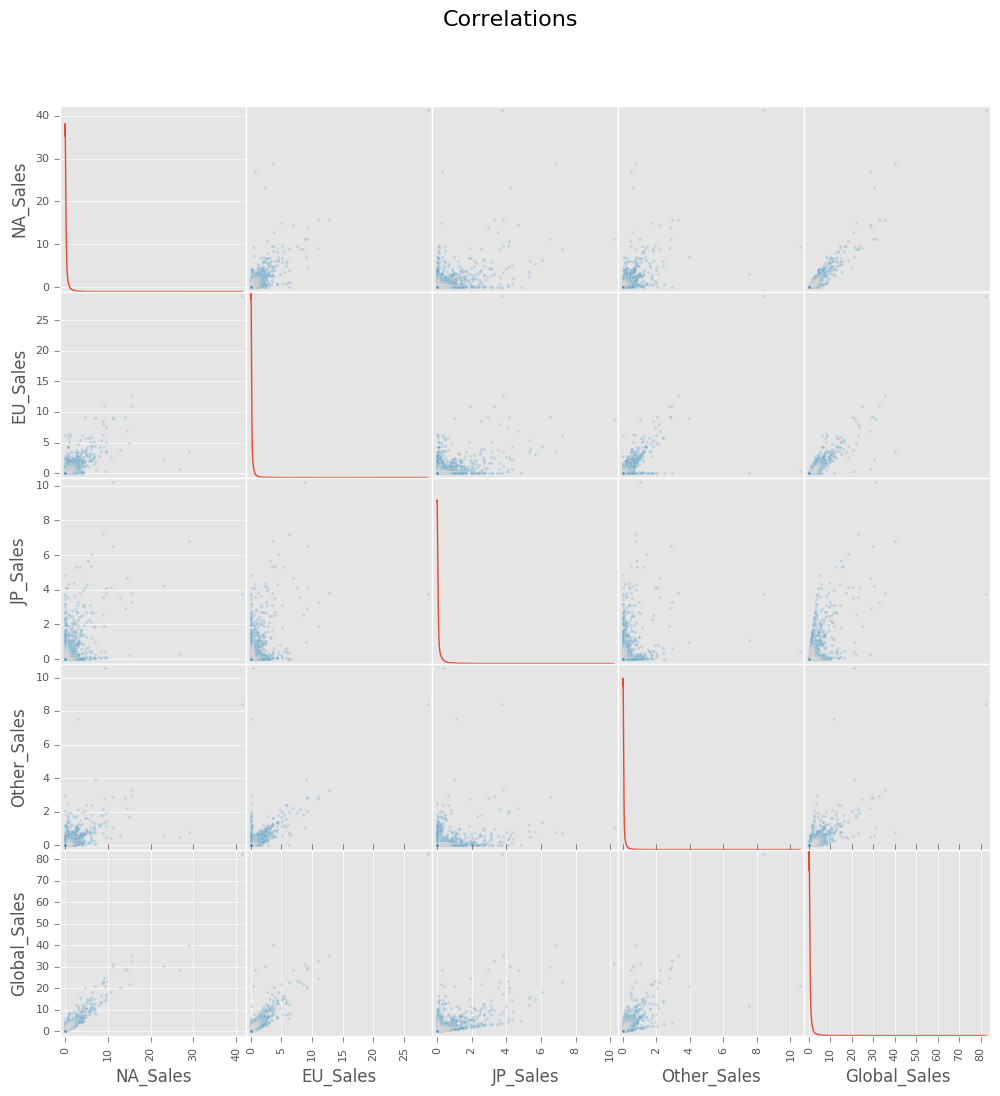

In [40]:
plotCorrelationsSales(raw_dataset, 'viz/correlations.png')

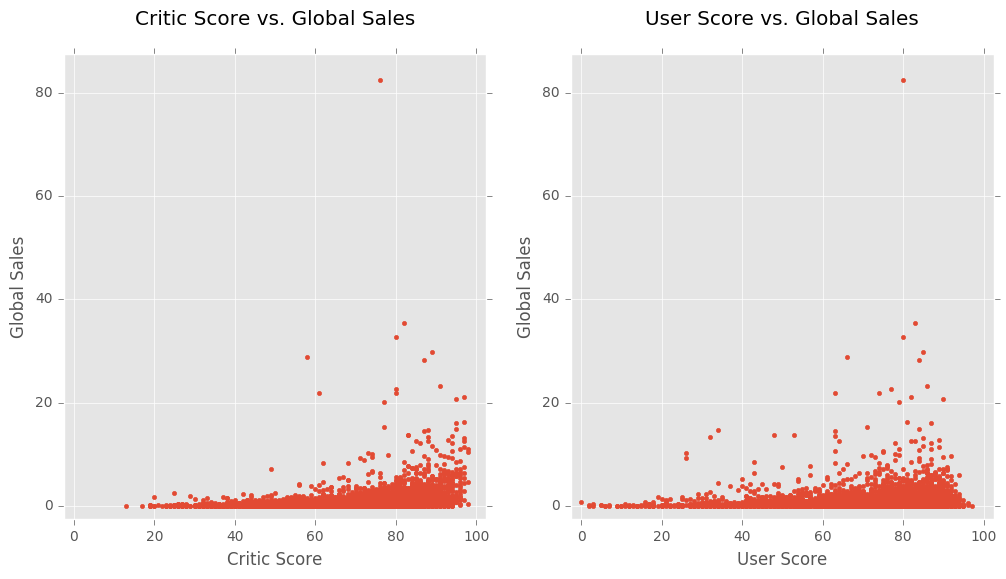

In [41]:
plotScoresVsSales(raw_dataset, 'viz/scores_vs_sales.png')

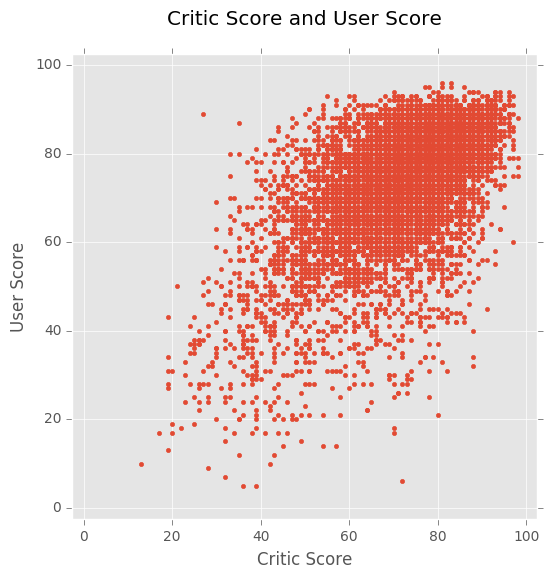

In [42]:
plotScoreComparison(raw_dataset, 'viz/score_comparison.png')

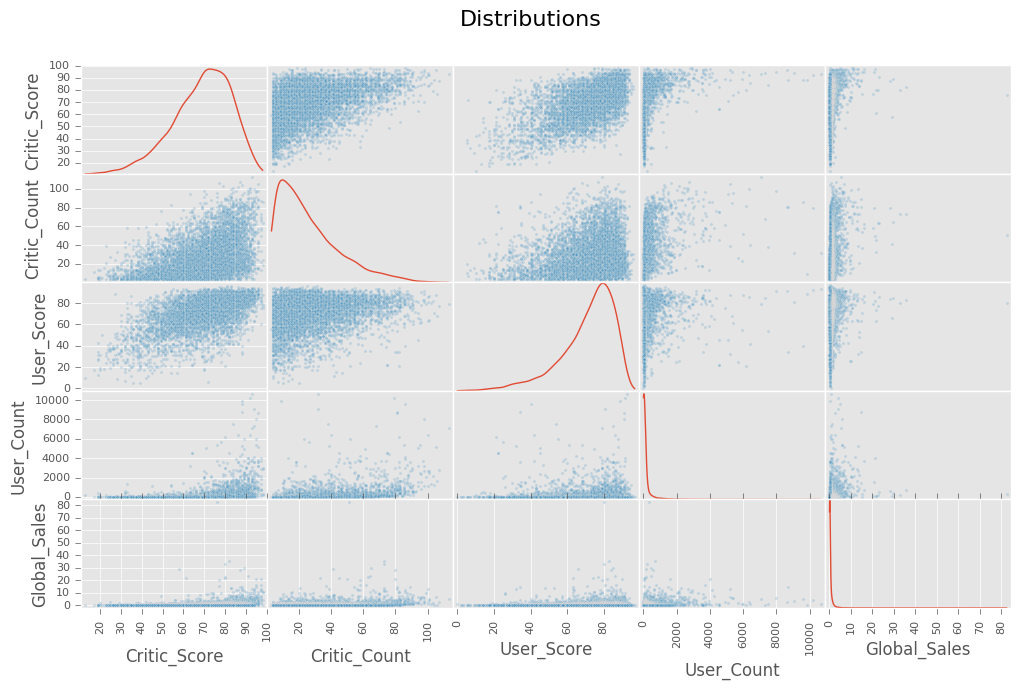

In [43]:
plotDistributions(raw_dataset, 'viz/distributions.png')

In [44]:
# Sanitization
clean_dataset = sanitizeDatasets(raw_dataset)

#Prepare for removing rows
short_dataset = clean_dataset.copy()

groups = short_dataset['Global_Sales'].groupby(short_dataset['Year_of_Release'])
display(groups.sum())
# Remove years that are not fit for the analysis
short_dataset = removeOutliersYear(short_dataset.copy())


# Look for outliers regarding Sales
display(clean_dataset.sort_values(['Global_Sales'], ascending = False).head(15))

# Remove those games that also came in bundles
short_dataset = removeOutliersBundle(short_dataset.copy())

Year_of_Release
1985.0      0.03
1988.0      0.03
1992.0      0.03
1994.0      1.27
1996.0     20.10
1997.0     35.01
1998.0     43.18
1999.0     52.21
2000.0     81.24
2001.0    256.32
2002.0    296.78
2003.0    265.62
2004.0    323.79
2005.0    336.95
2006.0    422.86
2007.0    464.15
2008.0    504.09
2009.0    460.48
2010.0    417.33
2011.0    391.79
2012.0    292.82
2013.0    267.78
2014.0    192.43
2015.0    159.16
2016.0     91.60
Name: Global_Sales, dtype: float64

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,84.0,594.0,Nintendo,E
11,Mario Kart DS,DS,2005.0,Racing,Nintendo,9.71,7.47,4.13,1.90,23.21,91.0,64.0,86.0,464.0,Nintendo,E
13,Wii Fit,Wii,2007.0,Sports,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,77.0,146.0,Nintendo,E
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,61.0,45.0,63.0,106.0,Good Science Studio,E
15,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,80.0,33.0,74.0,52.0,Nintendo,E


In [45]:
# display some infos
print ('REMAINING ROWS IN DATASET: {}'.format(*short_dataset.shape))
print ('Dataset has games from {} unique years'.format(short_dataset['Year_of_Release'].unique().size))

display(short_dataset.sort_values(['Global_Sales'], ascending = False).head())

REMAINING ROWS IN DATASET: 6506
Dataset has games from 15 unique years


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81,95.0,80.0,90.0,1588.0,Rockstar North,M
24,Grand Theft Auto: Vice City,PS2,2002.0,Action,Take-Two Interactive,8.41,5.49,0.47,1.78,16.15,95.0,62.0,87.0,730.0,Rockstar North,M
32,Call of Duty: Black Ops,X360,2010.0,Shooter,Activision,9.70,3.68,0.11,1.13,14.61,87.0,89.0,63.0,1454.0,Treyarch,M
34,Call of Duty: Black Ops II,PS3,2012.0,Shooter,Activision,4.99,5.73,0.65,2.42,13.79,83.0,21.0,53.0,922.0,Treyarch,M
35,Call of Duty: Black Ops II,X360,2012.0,Shooter,Activision,8.25,4.24,0.07,1.12,13.67,83.0,73.0,48.0,2256.0,Treyarch,M


In [46]:
# feature generation and removal

# make feature for "platform manufacturer"
short_dataset = createFeaturePlatformManufacturer(short_dataset)

# make feature for "mobility"
short_dataset = createFeatureMobility(short_dataset)

# => too many unique values per feature for the dataset size, so features should be removed
short_dataset = short_dataset.drop(['Name', 'Publisher', 'Developer'], axis=1)

In [47]:
computeSkewness(short_dataset[['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']])

# transforming years wouldn't make sense (and it randomly is fairly normally distributed)
# transforming sales probably doesn't make sense either, "long tail"
# transforming count might be speculative
# transforming scores might be a way to go

skewness for Critic_Score is: -0.754925031412 (p=7.45620240147e-110)
skewness for Critic_Count is: 0.996746089559 (p=4.57360386607e-169)
skewness for User_Score is: -1.21531853431 (p=9.63920017794e-225)
skewness for User_Count is: 9.48193896366 (p=0.0)
skewness for Global_Sales is: 5.25788843464 (p=0.0)


In [48]:
display(short_dataset.head())

,Platform,Year_of_Release,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Platform_Manufacturer,Mobility
17,PS2,2004.0,Action,9.43,0.40,0.41,10.57,20.81,95.0,80.0,90.0,1588.0,M,Sony,Stationary
24,PS2,2002.0,Action,8.41,5.49,0.47,1.78,16.15,95.0,62.0,87.0,730.0,M,Sony,Stationary
32,X360,2010.0,Shooter,9.70,3.68,0.11,1.13,14.61,87.0,89.0,63.0,1454.0,M,Microsoft,Stationary
34,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,13.79,83.0,21.0,53.0,922.0,M,Sony,Stationary
35,X360,2012.0,Shooter,8.25,4.24,0.07,1.12,13.67,83.0,73.0,48.0,2256.0,M,Microsoft,Stationary


In [49]:
# For each feature find the data points with extreme high or low values

display(short_dataset.describe())
 
# We could construct outliers mathematically, but we probably only have representative outliers that should
# remain in the set (Chambers, 1986)

#short_dataset = removeOutliers(short_dataset.copy(), columns = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'], threshold = 1.5, multeity = 2)
#display(short_dataset.describe())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000,6506.000000
mean,2007.367046,0.353986,0.201814,0.051059,0.074617,0.681675,69.889179,29.030126,71.789425,158.506609
std,3.774902,0.612932,0.418729,0.208543,0.223513,1.173962,13.833539,18.940499,14.323470,540.081025
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,15.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,75.000000,26.000000
75%,2010.000000,0.390000,0.200000,0.010000,0.070000,0.740000,80.000000,40.000000,82.000000,83.000000
max,2015.000000,9.700000,6.420000,5.330000,10.570000,20.810000,97.000000,107.000000,96.000000,10665.000000


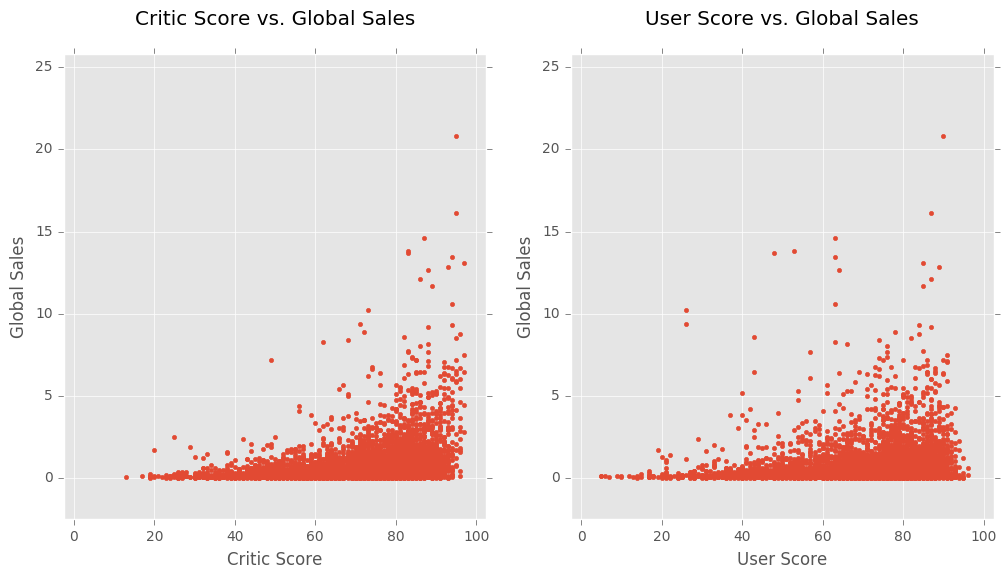

In [50]:
plotScoresVsSales(short_dataset, 'viz/scores_vs_sales_short_dataset.png')

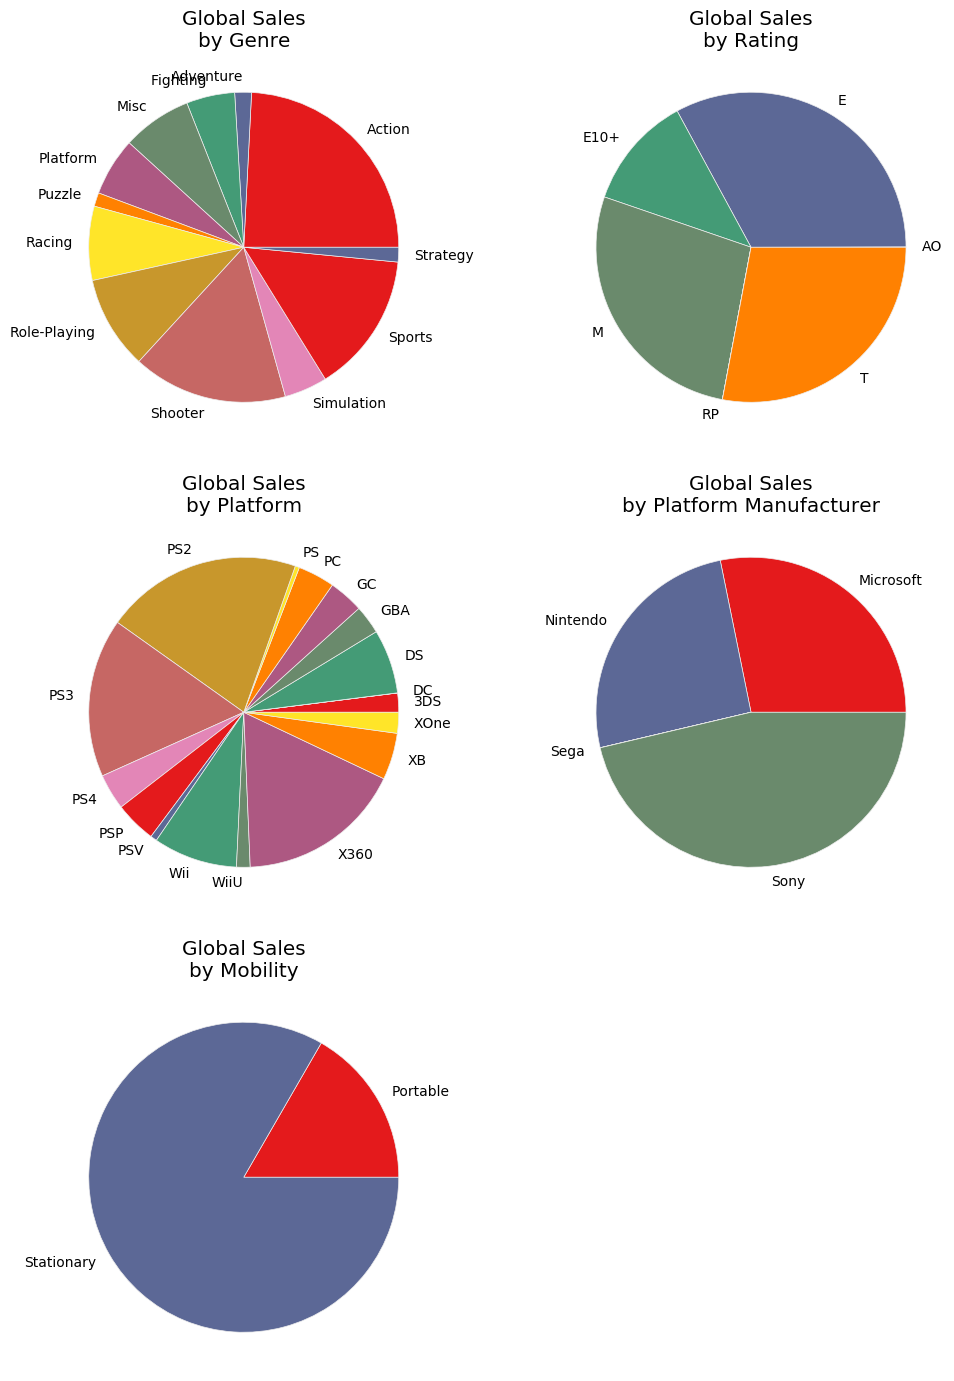

In [51]:
plotSalesByGroup(short_dataset, 'viz/sales_by_groups_short_dataset.png')

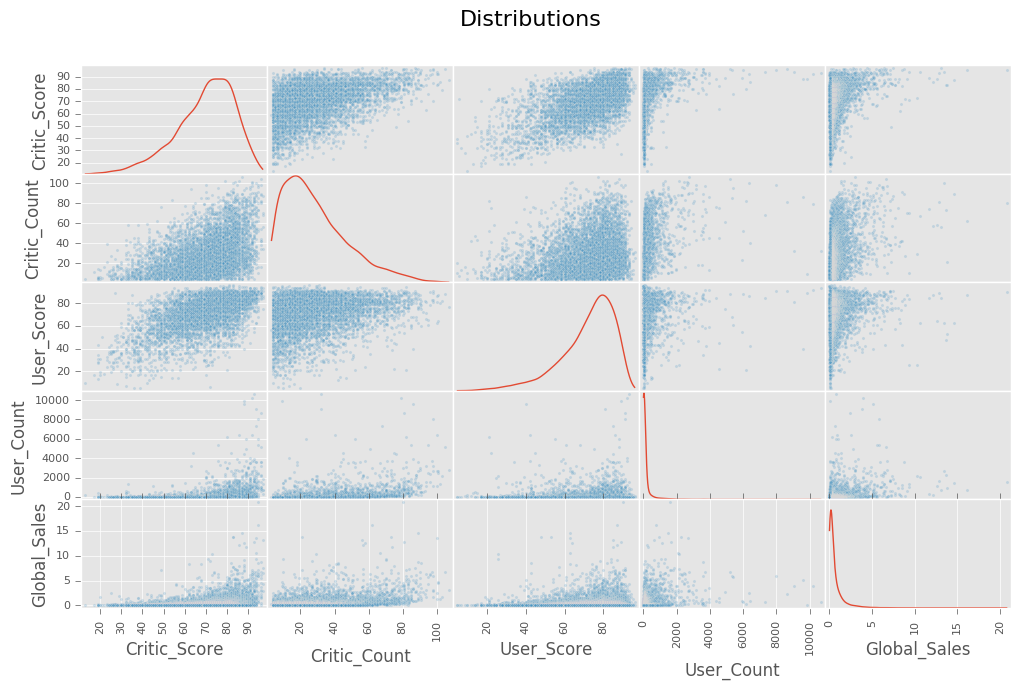

In [52]:
plotDistributions(short_dataset, 'viz/distributions_short_dataset.png')

In [53]:
# convert nominal features to boolean features
short_dataset = convertNominalFeatures(short_dataset, ['Mobility', 'Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
short_dataset = dropNominalFeatures(short_dataset)

In [54]:
# test_set
test_set1 = short_dataset.copy()

# standardize features
#short_dataset, std_scaler = standardizeDataFrame(short_dataset)

# scale features to range [0, 1]
#short_dataset, minmax_scaler = scaleDataFrame(short_dataset)

# run Box-Cox transformation => screws up, better r2, but only for transformed data
#short_dataset, boxcox_lmbdas = boxcoxDataFrame(short_dataset.copy(), columns=['Critic_Score', 'User_Score'])

In [55]:
# split data into training set and test set
# separate features from target values
features, sales = separateTargetValues(short_dataset)
test_features, test_sales = separateTargetValues(test_set1)

# get five best predictors
showKBest(features, sales['Global'])

# shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size=0.2, random_state=31415)

# Success
print "Training and testing split was successful."

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Mobility_Stationary,Mobility_Portable,Platform_PS2,Platform_X360,Platform_PS3,...,Rating_M,Rating_T,Rating_E,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Sony,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Sega
17,2004.0,95.0,80.0,90.0,1588.0,True,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
24,2002.0,95.0,62.0,87.0,730.0,True,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
32,2010.0,87.0,89.0,63.0,1454.0,True,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
34,2012.0,83.0,21.0,53.0,922.0,True,False,False,False,True,...,True,False,False,False,False,False,True,False,False,False
35,2012.0,83.0,73.0,48.0,2256.0,True,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False


,0,1,2,3,4
0,95.0,80.0,1588.0,0.0,0.0
1,95.0,62.0,730.0,0.0,0.0
2,87.0,89.0,1454.0,0.0,0.0
3,83.0,21.0,922.0,1.0,0.0
4,83.0,73.0,2256.0,0.0,0.0


Training and testing split was successful.


time.struct_time(tm_year=2017, tm_mon=3, tm_mday=4, tm_hour=14, tm_min=44, tm_sec=50, tm_wday=5, tm_yday=63, tm_isdst=0)

Regressor: Ridge(alpha=0.13, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.305
R² gap: 0.036


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


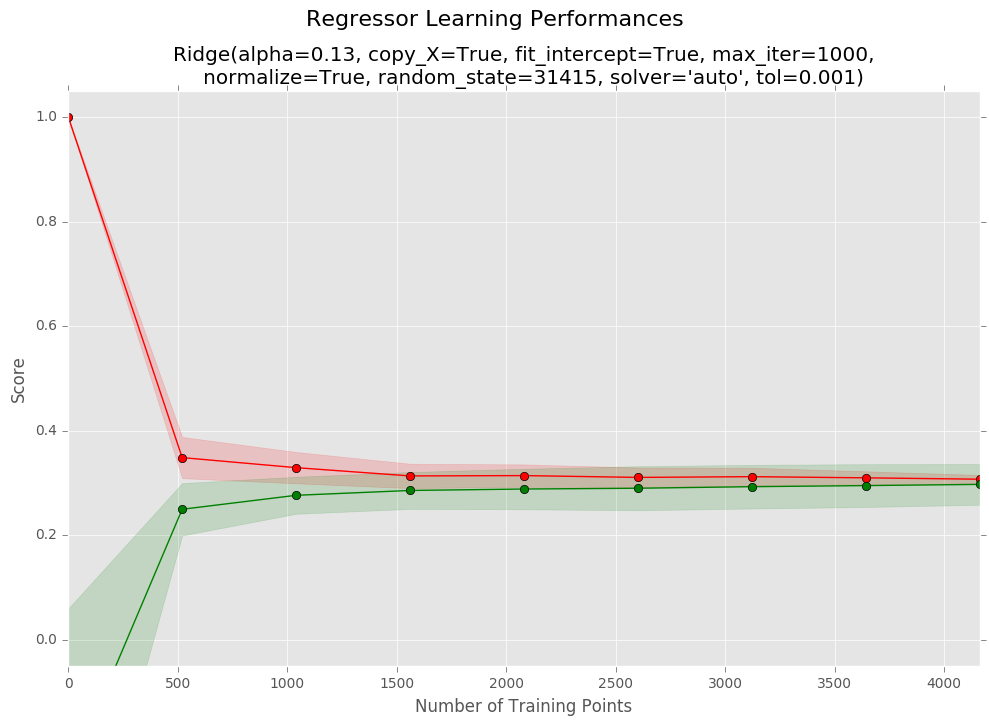

In [56]:
regressors = [0, 1, 2, 3, 4, 5]
reg_params = [0, 1, 2, 3, 4, 5]

random_state = 31415
n_splits = 20
test_size = 0.2

# create a RidgeRegression regressor object
regressor = Ridge(random_state = random_state)
params = {'alpha': [0.07, 0.1, 0.13],    # positve float
          'fit_intercept': [True, False], # boolean
          'max_iter': [1000],             # integer
          'normalize': [True, False],     # boolean
          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
         }
regressors[0] = regressor
reg_params[0] = params

# create a support vector regressor object
regressor = svm.SVR()
params = {'C': [0.7, 1.0, 1.3],
          'kernel': ['rbf'],
          'epsilon': [0.27, 0.3, 0.33],
          'gamma': ['auto']
         }       
regressors[1] = regressor
reg_params[1] = params

# create a decision tree regressor object
regressor = DecisionTreeRegressor(random_state = random_state)
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
regressors[2] = regressor
reg_params[2] = params

# create a LarsLasso regressor object
regressor = LassoLars()
params = {'alpha': [0.07, 0.1, 0.13],
          'fit_intercept': [True, False],
          'positive': [True, False],
          'normalize': [True, False],
          'max_iter': [1000]
         }
regressors[3] = regressor
reg_params[3] = params

# create a ElasticNet regressor object
regressor = ElasticNet()
params = {'alpha': [0.07, 0.1, 1.3],
          'l1_ratio': [0.1, 0.3, 0.7],
          'fit_intercept': [True, False],
          'normalize': [True, False],
          'max_iter' : [1000]
         }
regressors[4] = regressor
reg_params[4] = params

# create a Neural Network regressor object
regressor = MLPRegressor(random_state = random_state)
params = {'hidden_layer_sizes': [(150,)],
          'solver': ['lbfgs', 'sgd', 'adam']
         }
regressors[5] = regressor
reg_params[5] = params

total_start_time = time.time()
display(time.localtime(total_start_time))

results_columns = ['Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

for index in range(1):
#for index in range(len(regressors)):
    start_time = time.time()
    # Fit the training data to the model using grid search
    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
    end_time = time.time()
    
    print 'Regressor: {}'.format(reg)
    print 'R² score (train): {:.3f}'.format(reg_score_train)
    print 'R² gap: {:.3f}'.format(reg_gap)
    
    displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

In [ ]:
#STANDARDIZE_SET   = False
#SCALE_SET_0_1     = False
#BOXCOX_SET        = False
#OUTLIER_THRESHOLD = 1.5
#OUTLIER_MULTIETY  = 2
#N_SPLITS          = 20
#TEST_SIZE         = 0.2
#RANDOM_STATE      = 31415

params_standardize_set = [False, True]
params_scale_set_0_1   = [False, True]
params_boxcox_set      = [False]
params_outlier_threshold = [1.5, 1.7, 2.0]
params_outlier_multiety = [1, 2, 3]
params_n_splits = [20]
params_test_size = [0.2, 0.25]
params_random_state = [31415]

combinations = len(params_standardize_set) * len(params_scale_set_0_1) * len(params_boxcox_set) * len(params_outlier_threshold) * len(params_outlier_multiety) * len(params_n_splits) * len(params_test_size) * len(params_random_state)

results_columns = ['Id', 'Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

rid = 1
best_r2 = (0, -1)
best_gap = (0, -1)

for standardize_set in params_standardize_set:
    for scale_set_0_1 in params_scale_set_0_1:
        for boxcox_set in params_boxcox_set:
            for outlier_threshold in params_outlier_threshold:
                for outlier_multiety in params_outlier_multiety:
                    for n_splits in params_n_splits:
                        for test_size in params_test_size:
                            for random_state in params_random_state:
                                # boxcox does not work on values <= 0
                                if (boxcox_set == True):
                                    standardize_set = False
                                X_train, y_train, X_test, y_test = prepare_sets(standardize_set, scale_set_0_1, boxcox_set, outlier_threshold, outlier_multiety, n_splits, test_size, random_state)
                               
                                regressors = [0, 1, 2, 3, 4, 5]
                                reg_params = [0, 1, 2, 3, 4, 5]

                                # create a RidgeRegression regressor object
                                regressor = Ridge(random_state = random_state)
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13, 0.17],    # positve float
                                          'fit_intercept': [True, False], # boolean
                                          'max_iter': [1200],             # integer
                                          'normalize': [True, False],     # boolean
                                          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
                                         }
                                regressors[0] = regressor
                                reg_params[0] = params

                                # create a support vector regressor object
                                regressor = svm.SVR()
                                params = {'C': [0.7, 1.0, 1.3],
                                          'kernel': ['rbf'],
                                          'epsilon': [0.1, 0.3, 0.7, 1.0],
                                          'gamma': ['auto']
                                         }       
                                regressors[1] = regressor
                                reg_params[1] = params

                                # create a decision tree regressor object
                                regressor = DecisionTreeRegressor(random_state = random_state)
                                params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
                                regressors[2] = regressor
                                reg_params[2] = params

                                # create a LarsLasso regressor object
                                regressor = LassoLars()
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13, 0.17],
                                          'fit_intercept': [True, False],
                                          'positive': [True, False],
                                          'normalize': [True, False],
                                          'max_iter': [1200, 1500]
                                         }
                                regressors[3] = regressor
                                reg_params[3] = params

                                # create a ElasticNet regressor object
                                regressor = ElasticNet()
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13, 0.17],
                                          'l1_ratio': [0, 0.1, 0.2, 0.3],
                                          'fit_intercept': [True, False],
                                          'normalize': [True, False],
                                          'max_iter' : [1200]
                                         }
                                regressors[4] = regressor
                                reg_params[4] = params

                                # create a Neural Network regressor object
                                regressor = MLPRegressor(random_state = random_state)
                                params = {'hidden_layer_sizes': [(150,), (200,), (250,)],
                                          'alpha': [0.00093, 0.00097, 0.0001, 0.00013],
                                          'solver': ['lbfgs', 'sgd', 'adam']
                                         }
                                regressors[5] = regressor
                                reg_params[5] = params

                                total_start_time = time.time()
                                display(time.localtime(total_start_time))
                                
                                regs = range(5)
                                #regs = range(len(regressors))
                                
                                for index in regs:
                                    start_time = time.time()
                                    # Fit the training data to the model using grid search
                                    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
                                    end_time = time.time()
                                    
                                    print('ID: {} (of {})'.format(rid, combinations * len(regs)))
                                    print('standardize_set={}, scale_set_0_1={}, boxcox_set={}'.format(standardize_set, scale_set_0_1, boxcox_set))
                                    print('outlier_threshold={}, outlier_multiety={}'.format(outlier_threshold, outlier_multiety))
                                    print('n_splits={}, test_size={}, random_state={}'.format(n_splits, test_size, random_state))
                                    print('X_train.shape={}'.format(X_train.shape))
                                    print('Regressor: {}'.format(reg))
                                    print('R² score (train): {:.3f}'.format(reg_score_train))
                                    print('R² gap: {:.3f}'.format(reg_gap))
                                    print('==============================')

                                    if ((reg_score_train > best_r2[0]) | (best_r2[1] < 0)):
                                        best_r2 = (reg_score_train, rid)
                                    if ((reg_gap < best_gap[0]) | (best_gap[1] < 0)):
                                        best_gap = (reg_gap, rid)
                                        
                                    print('best r2: {} / best gap: {}'.format(best_r2, best_gap))
                                    print('==============================')
                                    
                                    #displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

                                    result = pd.DataFrame(
                                        [[
                                                rid,
                                                reg,
                                                reg_score_train,
                                                reg_score_test,
                                                reg_gap,
                                                end_time - start_time,
                                                standardize_set,
                                                scale_set_0_1,
                                                boxcox_set,
                                                outlier_threshold,
                                                outlier_multiety,
                                                test_size,
                                                n_splits,
                                                random_state
                                            ]],
                                        columns = results_columns)
                                    results = results.append(result)
                                    rid = rid + 1
 
display(results)
print('BEST R²')
display(results.nlargest(1, 'R2_Train').head())
print('BEST GAP')
display(results.nsmallest(1, 'R2_Gap').head())

results.to_csv('results_large_grid.csv')

time.struct_time(tm_year=2017, tm_mon=3, tm_mday=4, tm_hour=14, tm_min=48, tm_sec=14, tm_wday=5, tm_yday=63, tm_isdst=0)

ID: 1 (of 360)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=20, test_size=0.2, random_state=31415
X_train.shape=(4977, 46)
Regressor: Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.082
best r2: (0.27809139378808878, 1) / best gap: (0.082467016464008669, 1)


In [467]:
results = pd.read_csv("results_large_grid.csv")

display(results[(results['R2_Gap'] <= 0.1) & (results['R2_Train'] > 0.3)])

display(results['R2_Train'].groupby(results['Standardized']).mean())
display(results['R2_Train'].groupby(results['Scaled_0_1']).mean())
display(results['R2_Train'].groupby(results['Outlier_Threshold']).mean())
display(results['R2_Train'].groupby(results['Outlier_Multiety']).mean())
display(results['R2_Train'].groupby(results['Test_Size']).mean())
display(results['R2_Train'].groupby(results['N_Splits']).mean())

display(results['R2_Gap'].groupby(results['Standardized']).mean())
display(results['R2_Gap'].groupby(results['Scaled_0_1']).mean())
display(results['R2_Gap'].groupby(results['Outlier_Threshold']).mean())
display(results['R2_Gap'].groupby(results['Outlier_Multiety']).mean())
display(results['R2_Gap'].groupby(results['Test_Size']).mean())
display(results['R2_Gap'].groupby(results['N_Splits']).mean())

,Unnamed: 0,Id,Regressor,R2_Train,R2_Test,R2_Gap,Calc_Time,Standardized,Scaled_0_1,Boxcoxed,Outlier_Threshold,Outlier_Multiety,Test_Size,N_Splits,RND
32,0,33,"DecisionTreeRegressor(criterion='mse', max_dep...",0.331925,0.245100,0.086825,4.165,False,False,False,1.7,1.0,0.20,15.0,31415.0
52,0,53,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,5.701,False,False,False,1.7,3.0,0.20,15.0,31415.0
57,0,58,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,5.290,False,False,False,1.7,3.0,0.25,15.0,31415.0
142,0,143,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,3.041,False,True,False,1.7,3.0,0.20,15.0,31415.0
147,0,148,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,2.994,False,True,False,1.7,3.0,0.25,15.0,31415.0
201,0,202,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.398296,0.315630,0.082666,215.371,True,False,False,1.5,3.0,0.20,15.0,31415.0
206,0,207,"SVR(C=1.3, cache_size=200, coef0=0.0, degree=3...",0.398296,0.315630,0.082666,195.782,True,False,False,1.5,3.0,0.25,15.0,31415.0
212,0,213,"DecisionTreeRegressor(criterion='mse', max_dep...",0.331925,0.245100,0.086825,2.285,True,False,False,1.7,1.0,0.20,15.0,31415.0
237,0,238,"DecisionTreeRegressor(criterion='mse', max_dep...",0.364611,0.351068,0.013543,2.937,True,False,False,1.7,3.0,0.25,15.0,31415.0
302,0,303,"DecisionTreeRegressor(criterion='mse', max_dep...",0.331925,0.245100,0.086825,2375.000,True,True,False,1.7,1.0,0.20,15.0,31415.0


Standardized
False    0.042623
True     0.022252
Name: R2_Train, dtype: float64

Scaled_0_1
False    0.277131
True    -0.212256
Name: R2_Train, dtype: float64

Outlier_Threshold
1.5    0.018166
1.7    0.032029
2.0    0.047117
Name: R2_Train, dtype: float64

Outlier_Multiety
1.0    0.039502
2.0   -0.136747
3.0    0.194557
Name: R2_Train, dtype: float64

Test_Size
0.20    0.033433
0.25    0.031442
Name: R2_Train, dtype: float64

N_Splits
10.0    0.031806
15.0    0.034647
20.0    0.030859
Name: R2_Train, dtype: float64

Standardized
False    0.594539
True     0.568843
Name: R2_Gap, dtype: float64

Scaled_0_1
False    0.218579
True     0.944802
Name: R2_Gap, dtype: float64

Outlier_Threshold
1.5    0.311780
1.7    0.686420
2.0    0.746872
Name: R2_Gap, dtype: float64

Outlier_Multiety
1.0    0.247729
2.0    1.345057
3.0    0.152286
Name: R2_Gap, dtype: float64

Test_Size
0.20    0.580860
0.25    0.582522
Name: R2_Gap, dtype: float64

N_Splits
10.0    0.665266
15.0    0.620585
20.0    0.459221
Name: R2_Gap, dtype: float64